In [1]:
import os
import errno
import numpy as np 
import deepcell
from deepcell_toolbox.processing import phase_preprocess

In [2]:
# create folder for this set of experiments
experiment_folder = "20200619_production_updates"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [5]:
npz1 = np.load(NPZ_DIR + '20200524_IF_Training_8_copy.npz')
# npz2 = np.load(NPZ_DIR + 'Eliot_20200514_256x256_stride_0.5.npz')
# npz1 = np.load(NPZ_DIR + 'cHL_256x256_stride_0.5.npz')
npz2 = np.load(NPZ_DIR + 'CyCIF_256x256_stride_0.5_copy.npz')
npz3 = np.load(NPZ_DIR + '20200518_christine_CyCIF_256_0.5.npz')
#npz2 = np.load(NPZ_DIR + '20200518_christine_CyCIF_256_0.5.npz')

In [6]:
combined_x = np.concatenate((npz1['X'], npz2['X'], npz3['X']), axis=0)
combined_y = np.concatenate((npz1['y'], npz2['y'], npz3['y']), axis=0)

#np.savez(NPZ_DIR + '20200514_IF_Training_8.npz', X=combined_x, y=combined_y)
np.savez(NPZ_DIR + '20200524_IF_Training_9.npz', X=combined_x, y=combined_y)

In [7]:
combined_x.shape

(3158, 256, 256, 2)

In [82]:
from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "20200514_IF_Training_8"
npz_name = "20200521_IF_Training_256"
npz_name = "20200611_all_data"
# npz_name = '20200615_ML_256x256'

test_size=0.1
seed=0
DATA_FILE = NPZ_DIR + npz_name + ".npz"
train_dict, val_dict = get_data(DATA_FILE, test_size=test_size, seed=seed)
X_train, y_train = train_dict['X'], train_dict['y']
X_val, y_val = val_dict['X'], val_dict['y']

X.shape: (4510, 256, 256, 2)
y.shape: (4510, 256, 256, 1)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78.]


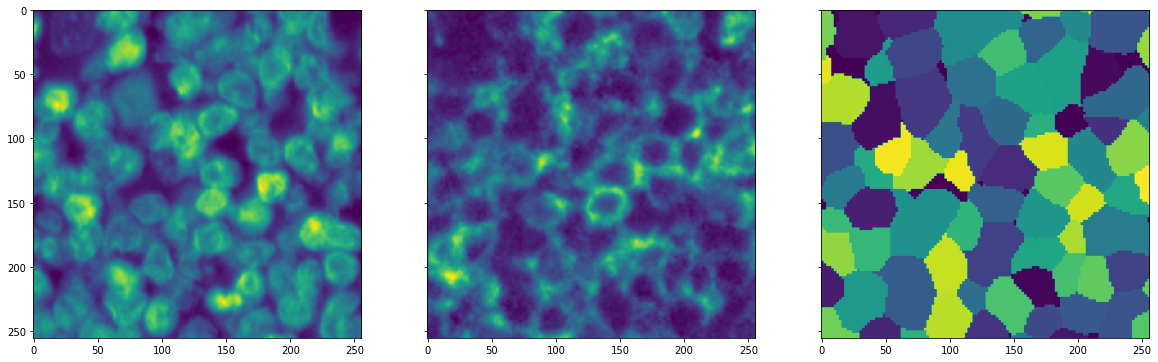

In [83]:
for i in range(y_train.shape[0]):
        y_train[i], _, _ = relabel_sequential(y_train[i])
        
for i in range(y_val.shape[0]):
        y_val[i], _, _ = relabel_sequential(y_val[i])
        
               
print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 20), sharex=True, sharey=True)

idx = 103
axes[0].imshow(X_train[idx,:,:,0])
axes[1].imshow(X_train[idx,:,:,1])
axes[2].imshow(y_train[idx,:,:,0])
print(np.unique(y_train[idx]))

In [84]:
k=128
X_train = phase_preprocess(X_train, k)
X_val = phase_preprocess(X_val, k)

In [93]:
from deepcell.model_zoo.panopticnet import PanopticNet

new_model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 3),
    norm_method=None,
    num_semantic_heads=4,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

In [79]:
old_model.load_weights('/data/models/20200610_param_tuning/20200612_all_data_512x512_deep_watershed_all_params.h5')

In [94]:
for i, layer in enumerate(new_model.layers):
    if layer.get_weights() == []:
        pass
    if layer.name == 'conv_channels':
        pass
    else:
        old_weights = old_model.layers[i].get_weights()
        new_model.layers[i].set_weights(old_weights)

In [95]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = npz_name + '_deep_watershed_tranfser_test'

n_epoch = 40  # Number of training epochs

optimizer = Adam(lr=1e-4, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-4, decay=0.99)

batch_size = 8

min_objects = 3  # throw out images with fewer than this many objects
seed=0
model_name

'20200611_all_data_deep_watershed_tranfser_test'

In [97]:
X_train_new = np.zeros((4510, 256, 256, 3))
X_train_new[:, :, :, :2] = X_train


X_val_new = np.zeros((502, 256, 256, 3))
X_val_new[:, :, :, :2] = X_val

In [92]:
X_val.shape

(502, 256, 256, 2)

In [99]:
from deepcell import image_generators
from deepcell.utils import train_utils


# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)
    
train_data = datagen.flow(
    {'X': X_train_new[:600], 'y': y_train[:600]},
    seed=seed,
    transforms=['inner-distance', 'watershed-cont', 'fgbg', 'pixelwise'],
    transforms_kwargs={'watershed-cont': {'erosion_width': 2}, 'pixelwise':{'dilation_radius': 1}, 
                      'inner-distance': {'erosion_width': 2, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_val_new[:60], 'y': y_val[:60]},
    seed=seed,
    transforms=['inner-distance', 'watershed-cont', 'fgbg', 'pixelwise'],
    transforms_kwargs={'watershed-cont': {'erosion_width': 2}, 'pixelwise':{'dilation_radius': 1},
                      'inner-distance': {'erosion_width': 2, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

W0704 19:17:35.726725 139757924542272 semantic.py:158] Removing 28 of 600 images with fewer than 3 objects.
W0704 19:17:51.794349 139757924542272 semantic.py:158] Removing 4 of 60 images with fewer than 3 objects.


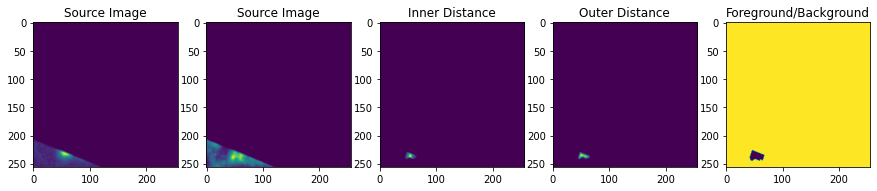

In [100]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]
#pixelwise = outputs[3]

fig, axes = plt.subplots(1, 5, figsize=(15, 15))

axes[0].imshow(img[:, :, 0])
axes[0].set_title('Source Image')

axes[1].imshow(img[:, :, 1])
axes[1].set_title('Source Image')

axes[2].imshow(inner_distance[0, ..., 0])
axes[2].set_title('Inner Distance')

axes[3].imshow(outer_distance[0, ..., 0])
axes[3].set_title('Outer Distance')

axes[4].imshow(fgbg[0, ..., 0])
axes[4].set_title('Foreground/Background')

plt.show()

In [101]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in new_model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [102]:
new_model.compile(loss=loss, optimizer=optimizer)

In [103]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus


model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = new_model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/40
70/71 [============================>.] - ETA: 0s - loss: 0.0668 - semantic_0_loss: 0.0197 - semantic_1_loss: 0.0380 - semantic_2_loss: 0.0028 - semantic_3_loss: 0.0063
Epoch 00001: val_loss improved from inf to 0.06068, saving model to /data/models/20200619_production_updates/20200611_all_data_deep_watershed_tranfser_test.h5
71/71 [==============================] - 71s 1s/step - loss: 0.0666 - semantic_0_loss: 0.0197 - semantic_1_loss: 0.0378 - semantic_2_loss: 0.0028 - semantic_3_loss: 0.0063 - val_loss: 0.0607 - val_semantic_0_loss: 0.0206 - val_semantic_1_loss: 0.0311 - val_semantic_2_loss: 0.0028 - val_semantic_3_loss: 0.0062
Epoch 2/40
70/71 [============================>.] - ETA: 0s - loss: 0.0548 - semantic_0_loss: 0.0165 - semantic_1_loss: 0.0306 - semantic_2_loss: 0.0022 - semantic_3_loss: 0.0055
Epoch 00002: val_loss improved from 0.06068 to 0.05028, saving model to /data/models/20200619_production_updates/20200611_all_data_deep_watershed_tranfs

Epoch 15/40
70/71 [============================>.] - ETA: 0s - loss: 0.0475 - semantic_0_loss: 0.0143 - semantic_1_loss: 0.0262 - semantic_2_loss: 0.0019 - semantic_3_loss: 0.0050
Epoch 00015: val_loss did not improve from 0.04283
71/71 [==============================] - 21s 295ms/step - loss: 0.0475 - semantic_0_loss: 0.0143 - semantic_1_loss: 0.0263 - semantic_2_loss: 0.0019 - semantic_3_loss: 0.0051 - val_loss: 0.0447 - val_semantic_0_loss: 0.0146 - val_semantic_1_loss: 0.0220 - val_semantic_2_loss: 0.0025 - val_semantic_3_loss: 0.0056
Epoch 16/40
70/71 [============================>.] - ETA: 0s - loss: 0.0470 - semantic_0_loss: 0.0141 - semantic_1_loss: 0.0260 - semantic_2_loss: 0.0019 - semantic_3_loss: 0.0050
Epoch 00016: val_loss did not improve from 0.04283
71/71 [==============================] - 21s 292ms/step - loss: 0.0470 - semantic_0_loss: 0.0141 - semantic_1_loss: 0.0260 - semantic_2_loss: 0.0019 - semantic_3_loss: 0.0050 - val_loss: 0.0441 - val_semantic_0_loss: 0.0149 

KeyboardInterrupt: 

In [143]:
test_data = np.load('/data/segmentation/datasets/20200610_test_freeze/MIBI_DCIS_test_data.npz')
X_test, y_test = test_data['X'], test_data['y']
X_test_crop, y_test_crop = X_test[:, 256:, 256:, :2], y_test[:, 256:, 256:, :]

In [20]:
from deepcell_toolbox.processing import phase_preprocess
X_test_crop_adjusted = phase_preprocess(X_val[:10])

In [27]:
y_test_crop = y_val[:10]

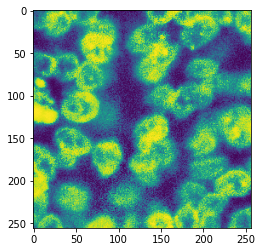

In [24]:
import matplotlib.pyplot as plt
plt.imshow(X_test_crop_adjusted[0, :, :, 0])

In [105]:
# from deepcell.applications import MultiplexSegmentation
# app = MultiplexSegmentation(use_pretrained_weights=False)
# # app.model.load_weights(os.path.join(MODEL_DIR, model_name + '.h5'))
# app.model.load_weights('/data/models/20200610_param_tuning/20200612_all_data_512x512_deep_watershed_all_params.h5')
# model.load_weights('/data/models/20200610_param_tuning/20200612_all_data_512x512_deep_watershed_all_params.h5')

In [31]:
from deepcell_toolbox.deep_watershed import deep_watershed_mibi
#inner_distance, outer_distance, fgbg, pixelwise = app._run_model(X_test_adjusted[:, :, :, :2])
inner_distance, outer_distance, fgbg, pixelwise = model.predict(X_test_crop_adjusted)
labeled_images = deep_watershed_mibi([inner_distance, outer_distance, fgbg, pixelwise], detection_threshold=0.05)

In [26]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                            [5, 95])
            rescaled_intensity = rescale_intensity(input_data[img, :, :, channel],
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')
            RGB_data[img, :, :, channel + 1] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries > 0, :] = 1
    
    return overlay_data

In [32]:
RGB_data = make_color_overlay(X_val[:10])
predicted_overlay = make_outline_overlay(RGB_data, labeled_images)
true_overlay = make_outline_overlay(RGB_data, y_test_crop[..., 0])

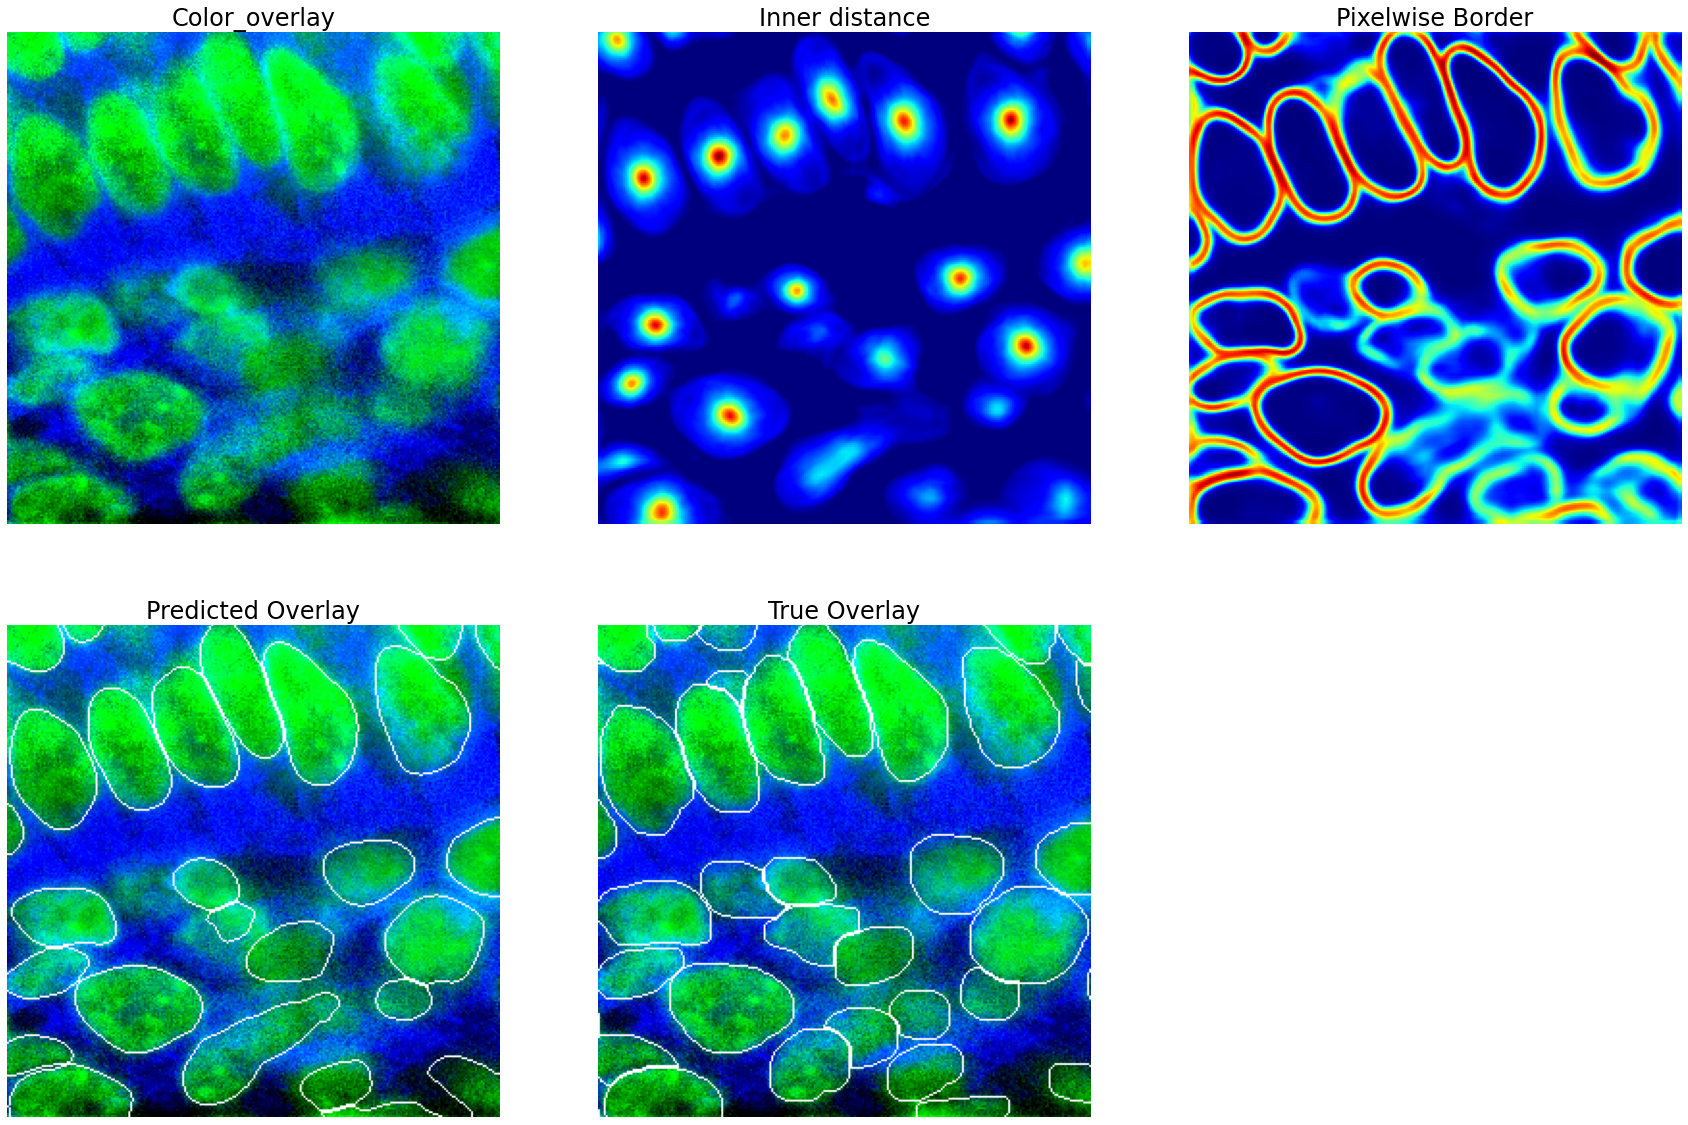

In [34]:
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = [1]
fig, axes = plt.subplots(2,3,figsize=(30,20))

axes = axes.flatten()
axes[0].imshow(RGB_data[index[0],...])
axes[1].imshow(inner_distance[index[0],...,0], cmap='jet')
axes[2].imshow(pixelwise[index[0],...,0], cmap='jet')
axes[3].imshow(predicted_overlay[index[0], ...], cmap=cmap)
axes[4].imshow(true_overlay[index[0], ...], cmap=cmap)

axes[0].set_title('Color_overlay', fontsize=24)
axes[1].set_title('Inner distance', fontsize=24)
axes[2].set_title('Pixelwise Border', fontsize=24)
axes[3].set_title('Predicted Overlay', fontsize=24)
axes[4].set_title('True Overlay', fontsize=24)
# axes[5].set_title('Ground Truth Mask', fontsize=24)

for ax in axes.flatten():
    ax.set_axis_off()